In [81]:
import pandas as pd
import time
import numpy as np

# Load the raw IMU CSV data
file_path = "data/imu.csv"
with open(file_path, "r") as f:
    lines = f.readlines()

# Define the parsing function

    def get_pitch_roll_from_gravity(gx, gy, gz):
        pitch = np.degrees(np.arcsin(-gx / np.linalg.norm([gx, gy, gz])))
        roll = np.degrees(np.arctan2(gy, gz))

        roll = ((roll + 90) % 180) - 90

        return pitch, roll

def quaternion_to_euler(q):
    """
    Convert a quaternion into Euler angles (roll, pitch, yaw).

    Args:
        q (list): Quaternion [x, y, z, w]

    Returns:
        tuple: (roll, pitch, yaw) in degrees
    """
    x, z, y, w = q

    # Roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)
    corrected_roll = (roll)# + (np.pi/2)

    # Pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    pitch = np.arcsin(np.clip(sinp, -1, 1))

    # Yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)
    corrected_yaw = (yaw + np.pi/2)
    return np.degrees(corrected_roll), np.degrees(pitch), np.degrees(corrected_yaw)

def parse_line(line):
    parts = line.strip().split(",")
    data = {}

    for part in parts:
        try:
            key, *values = part.split(":")
            if key in ["q", "a", "la", "g", "m", "grav"]:
                data[key] = [float(v) for v in values]
            elif key == "steps":
                data[key] = int(values[0])
            elif key == "stab":
                data[key] = values[0]
        except Exception as e:
            print(f"[IMU_BNO085] Parse error for {part}: {e}")

    if "q" in data:
        data["euler"] = quaternion_to_euler(data["q"])
    data["unix_time"] = time.time()

    return data

# Apply the function to each line
parsed_data = [parse_line(line) for line in lines]

# Convert to a DataFrame
df = pd.DataFrame(parsed_data)

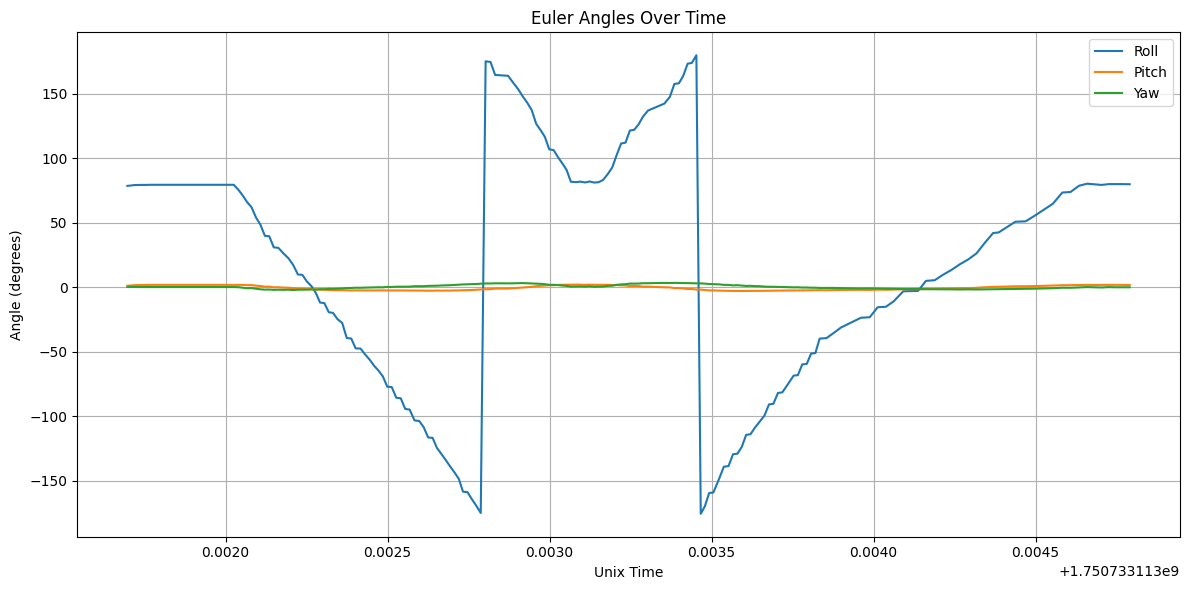

In [82]:
import matplotlib.pyplot as plt

# Extract Euler angles from the DataFrame
df_valid = df[df["euler"].notnull()].copy()
df_valid[["roll", "pitch", "yaw"]] = pd.DataFrame(df_valid["euler"].tolist(), index=df_valid.index)

# Plot pitch, yaw, and roll
plt.figure(figsize=(12, 6))
plt.plot(df_valid["unix_time"], df_valid["roll"], label="Roll")
plt.plot(df_valid["unix_time"], df_valid["pitch"], label="Pitch")
plt.plot(df_valid["unix_time"], df_valid["yaw"], label="Yaw")
plt.xlabel("Unix Time")
plt.ylabel("Angle (degrees)")
plt.title("Euler Angles Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

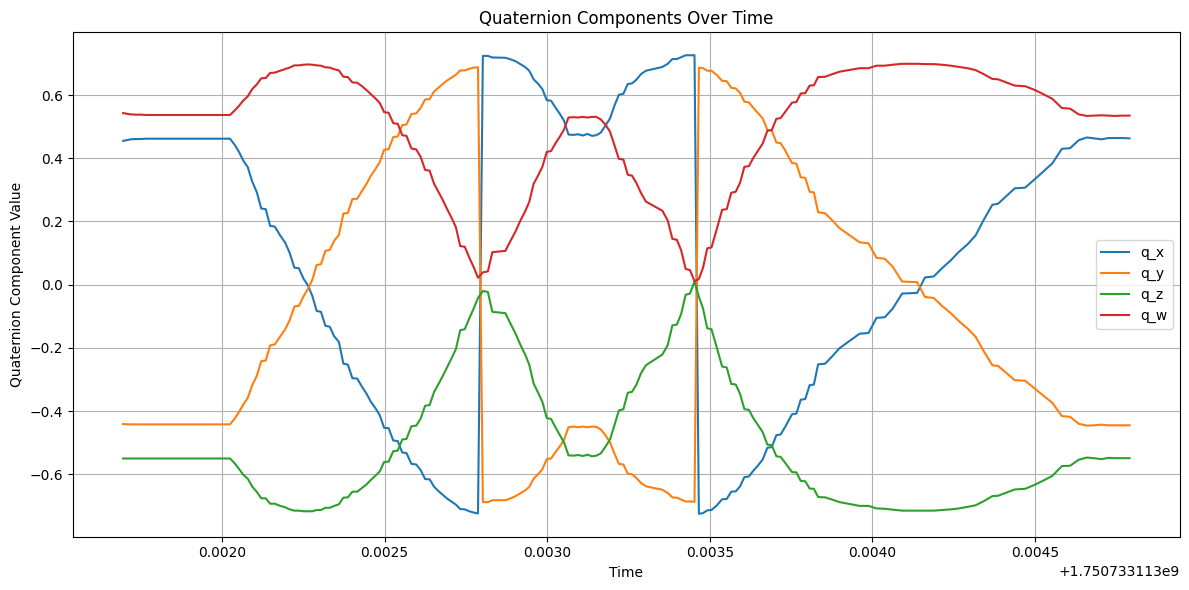

In [83]:
df_valid[["q_x", "q_z", "q_y", "q_w"]] = pd.DataFrame(df_valid["q"].tolist(), index=df_valid.index)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_valid["unix_time"], df_valid["q_x"], label="q_x")
plt.plot(df_valid["unix_time"], df_valid["q_y"], label="q_y")
plt.plot(df_valid["unix_time"], df_valid["q_z"], label="q_z")
plt.plot(df_valid["unix_time"], df_valid["q_w"], label="q_w")
plt.xlabel("Time")
plt.ylabel("Quaternion Component Value")
plt.title("Quaternion Components Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

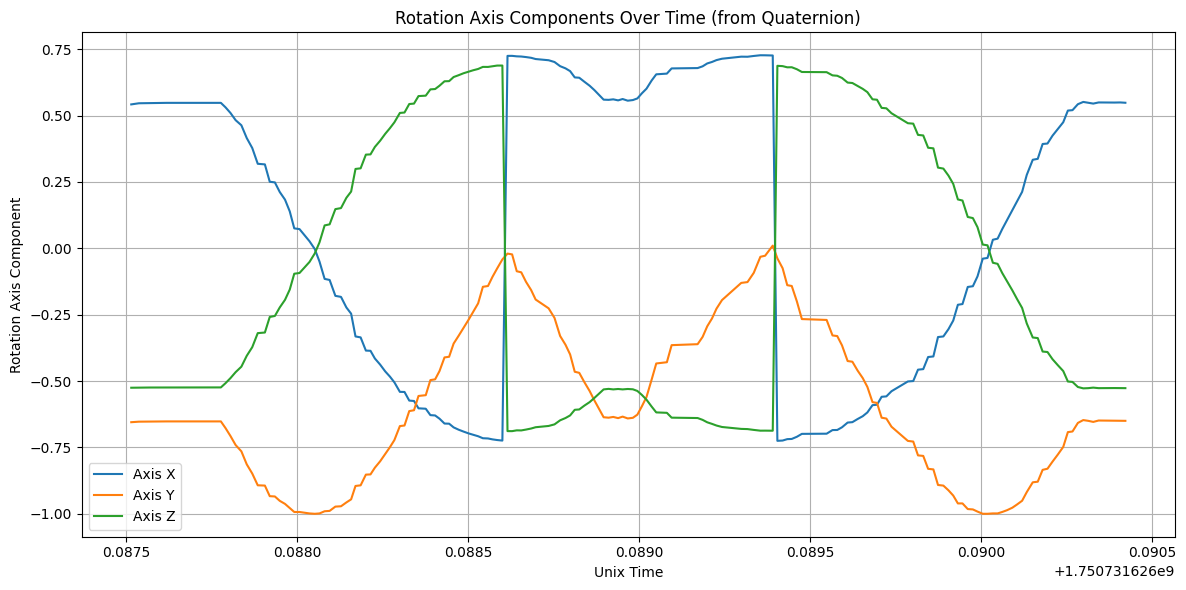

In [42]:
# Assume df_valid is already defined and contains a 'q' column with valid quaternions

# Function to extract rotation axis from quaternion
def get_rotation_axis(q):
    x, y, z, w = q
    angle = 2 * np.arccos(w)
    sin_half_angle = np.sqrt(1 - w**2)
    if sin_half_angle < 1e-6:
        return (0.0, 0.0, 0.0)  # angle is 0, axis undefined
    return (x / sin_half_angle, y / sin_half_angle, z / sin_half_angle)

# Apply function
df_valid["rot_axis"] = df_valid["q"].apply(get_rotation_axis)
df_valid[["axis_x", "axis_y", "axis_z"]] = pd.DataFrame(df_valid["rot_axis"].tolist(), index=df_valid.index)

# Plot rotation axis components over time
plt.figure(figsize=(12, 6))
plt.plot(df_valid["unix_time"], df_valid["axis_x"], label="Axis X")
plt.plot(df_valid["unix_time"], df_valid["axis_y"], label="Axis Y")
plt.plot(df_valid["unix_time"], df_valid["axis_z"], label="Axis Z")
plt.xlabel("Unix Time")
plt.ylabel("Rotation Axis Component")
plt.title("Rotation Axis Components Over Time (from Quaternion)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
